In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim import SGD
import glob
from torch.utils.data import random_split, Subset

In [97]:
class Task1Res(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1):
        super(Task1Res, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channel)
        )
        self.shortcut = nn.Sequential()
        if in_channel != out_channel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channel)
            )

    def forward(self, x):
        out = self.conv(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Task1Net(nn.Module):
    def __init__(self, Task1Res, num_classes=10):
        super(Task1Net, self).__init__()
        self.in_channel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.conv2 = self.layer(Task1Res, 64,  2, stride=1)
        self.fc = nn.Linear(in_features=64*16*16, out_features=num_classes)

    def layer(self, block, channels, num_blocks, stride):
#         strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        layers.append(block(self.in_channel, channels, stride))
        layers.append(block(self.in_channel, channels, stride))
#         for stride in strides:
#             layers.append(block(self.in_channel, channels, stride))
#             self.in_channel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def MyNet():
    return Task1Net(Task1Res)

In [98]:
print(MyNet())

Task1Net(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Task1Res(
      (conv): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): Task1Res(
      (conv): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64

In [103]:
classes = ['f','j','k','l','m','n','o','x','y','z']

transformer = transforms.Compose([
    transforms.ToTensor(),
#     transforms.RandomHorizontalFlip(),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), #R,G,B每层的归一化用到的均值和方差
    transforms.Normalize([0.5,0.5,0.5],
                        [0.5,0.5,0.5])
])

# TODO remove color (grey scale)
# TODO remove background maybe?

train_path = 'data_letters/train'
test_path = 'data_letters/test'

train_data = torchvision.datasets.ImageFolder(train_path, transform=transformer)

train_ratio = 0.8
train_size = int(train_ratio * len(train_data))
val_size = len(train_data) - train_size
train_set, val_set = random_split(train_data, [train_size, val_size])

trainloader = DataLoader(
    train_set,
    batch_size = 64,
    shuffle = True
)

valloader = DataLoader(
    val_set,
    batch_size = 64,
    shuffle = True
)

In [108]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# New training
model = MyNet()

# Continue training - load previous model
best_model = torch.load('model/task1-adam-decay.model')
model.load_state_dict(best_model, strict=False)

model.to(device)

# TODO: Optimizers SGD vs. Adam
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# optimizer = SGD(model.parameters(), lr=0.01)
# optimizer = SGD(model.parameters(), lr=0.001, weight_decay=1e-6)
loss_function = nn.CrossEntropyLoss()

num_epoches = 15

train_count = len(train_set)
val_count = len(val_set)

best_accuracy = 0.874

# hist_adam_decay = []

for epoch in range(30,45):
    model.to(device)
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        if torch.cuda.is_available():
            images = images.to(device)
            labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().data * images.size(0)
        _, prediction = torch.max(outputs.data,1)
        train_accuracy += int(torch.sum(prediction == labels.data))
    
    train_accuracy = train_accuracy / train_count
    train_loss = train_loss/train_count
    
    model.eval()
    val_accuracy = 0.0
    with torch.no_grad():
        for i, (images, labels) in enumerate(valloader):
            if torch.cuda.is_available():
                images = images.to(device)
                labels = labels.to(device)
            outputs = model(images)
            _,prediction = torch.max(outputs.data,1)
            val_accuracy += int(torch.sum(prediction==labels.data))

        val_accuracy = val_accuracy / val_count
        
        print(f"Epoch {epoch}")
        print(f"Train_accuracy {train_accuracy}")
        print(f"Train Loss {train_loss}")
        print(f"Val Accuracy {val_accuracy}")
        
        hist_adam_decay.append({ 
            'epoch':epoch,
            'train_accuracy':train_accuracy,
            'val_accuracy':val_accuracy,
            'best_accuracy':best_accuracy,
            'train_loss':train_loss
        })
        
        if val_accuracy > best_accuracy:
            print(f"Best Val Accuracy {val_accuracy}")
            torch.save(model.state_dict(), 'model/task1-adam-decay.model')
            best_accuracy = val_accuracy

Epoch 30
Train_accuracy 0.9969165085388995
Train Loss 0.013700011186301708
Val Accuracy 0.8743480322427691
Best Val Accuracy 0.8743480322427691
Epoch 31
Train_accuracy 0.999881404174573
Train Loss 0.0030572388786822557
Val Accuracy 0.8843053579895686
Best Val Accuracy 0.8843053579895686
Epoch 32
Train_accuracy 1.0
Train Loss 0.0009013264789246023
Val Accuracy 0.8847795163584637
Best Val Accuracy 0.8847795163584637
Epoch 33
Train_accuracy 1.0
Train Loss 0.00034702837001532316
Val Accuracy 0.8852536747273589
Best Val Accuracy 0.8852536747273589
Epoch 34
Train_accuracy 1.0
Train Loss 0.00019452738342806697
Val Accuracy 0.8852536747273589
Epoch 35
Train_accuracy 1.0
Train Loss 0.00012985932698938996
Val Accuracy 0.8838311996206734
Epoch 36
Train_accuracy 1.0
Train Loss 0.00010089064744533971
Val Accuracy 0.8819345661450925
Epoch 37
Train_accuracy 1.0
Train Loss 7.948929123813286e-05
Val Accuracy 0.8819345661450925


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [81]:
hist_fix = []
i = 0
for item in hist:
    if i <= 12:
        hist_fix.append(item)
    elif i % 2 == 1:
        hist_fix.append(item)
    i+=1

In [109]:
hist_adam_decay

[{'epoch': 0,
  'train_accuracy': 0.38543643263757116,
  'val_accuracy': 0.5794215267899478,
  'best_accuracy': 0.0,
  'train_loss': tensor(14.5280)},
 {'epoch': 1,
  'train_accuracy': 0.6609345351043643,
  'val_accuracy': 0.7126600284495022,
  'best_accuracy': 0.5794215267899478,
  'train_loss': tensor(0.9912)},
 {'epoch': 2,
  'train_accuracy': 0.7377846299810247,
  'val_accuracy': 0.7339971550497866,
  'best_accuracy': 0.7126600284495022,
  'train_loss': tensor(0.7725)},
 {'epoch': 3,
  'train_accuracy': 0.7503557874762808,
  'val_accuracy': 0.7852062588904695,
  'best_accuracy': 0.7339971550497866,
  'train_loss': tensor(0.7444)},
 {'epoch': 4,
  'train_accuracy': 0.8025379506641366,
  'val_accuracy': 0.8103366524419156,
  'best_accuracy': 0.7852062588904695,
  'train_loss': tensor(0.5942)},
 {'epoch': 5,
  'train_accuracy': 0.8223434535104365,
  'val_accuracy': 0.7823613086770982,
  'best_accuracy': 0.8103366524419156,
  'train_loss': tensor(0.5448)},
 {'epoch': 6,
  'train_accura

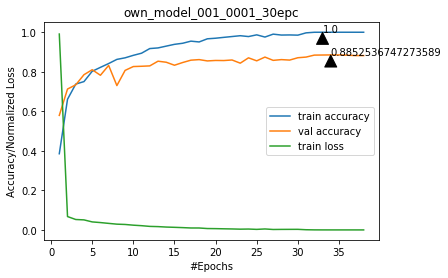

In [110]:
x = np.arange(1, len(hist_adam_decay)+1)

fig, ax = plt.subplots()  # Create a figure and an axes.
train_accuracy2 = list(map(lambda x: x['train_accuracy'], hist_adam_decay))
val_accuracy2 = list(map(lambda x: x['val_accuracy'], hist_adam_decay))

train_loss2 = list(map(lambda x: x['train_loss'], hist_adam_decay))
train_loss2 = train_loss2 / np.linalg.norm(train_loss2)

plt.plot(x, train_accuracy2, label='train accuracy')  # Plot some data on the axes.
plt.plot(x, val_accuracy2, label='val accuracy')  # Plot more data on the axes...
plt.plot(x, train_loss2, label='train loss')  # ... and some more.
plt.xlabel('#Epochs')  # Add an x-label to the axes.
plt.ylabel('Accuracy/Normalized Loss')  # Add a y-label to the axes.
plt.title("own_model_001_0001_30epc")  # Add a title to the axes.
plt.legend()  # Add a legend.

plt.annotate(f'{np.max(train_accuracy2)}', xy=(np.argmax(train_accuracy2) + 1, np.max(train_accuracy2)), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'{np.max(val_accuracy2)}', xy=(np.argmax(val_accuracy2) + 1, np.max(val_accuracy2)), arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()